# Change Point Analysis 

## Imports

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import numpy as np
import ruptures as rpt

In [19]:
def find_data_folder(folder_path, start_path='/content/drive'):
  '''
    :file_path: The complete path of the folder that includes the files.
    :start_path: The root folder on Drive from which we start the search.
  '''
  #Search the root folder of the data and if found, continue searching the full path.
  start_data_folder = folder_path.split('/')[0]
  for root, dirs, files in os.walk(start_path):
      if start_data_folder in dirs:
          return os.path.join(root, folder_path)
  raise Exception(f"{start_data_folder} folder not found. Please check the directory structure.")

def read_store_files(files_path, file_type='.csv'):
  '''
    :files_path: The complete Drive path that includes the files
  '''

  data_list = []
  files_names = []
  for file in os.listdir(files_path):
    if file.endswith(file_type):
      file_path = os.path.join(files_path, file)
      if file_type == '.csv':
        data = pd.read_csv(file_path)
      elif file_type == '.xlsx':
        data = pd.read_excel(file_path)

      data_list.append(data)
      files_names.append(file)

  return data_list, files_names

def zero_pad_filenames(annotation_files_names):
    # Create a list to hold the zero-padded filenames
    padded_filenames = []

    for filename in annotation_files_names:
        # Extract the number part from the filename
        parts = re.split(r'(\d+)', filename)
        # Zero-pad the number part
        parts[1] = parts[1].zfill(2)
        # Reconstruct the filename
        padded_filename = ''.join(parts)
        padded_filenames.append(padded_filename)

    return padded_filenames

def sort_data(files_names, data):
    # Get the zero-padded filenames
    padded_filenames = zero_pad_filenames(files_names)
    
    # Create a list of tuples (padded_filename, original_filename, annotation_data)
    combined_list = list(zip(padded_filenames, files_names, data))

    # Sort the combined list based on the zero-padded filenames
    combined_list.sort()

    # Unzip the sorted list back into the separate components
    sorted_filenames = [original_filename for _, original_filename, _ in combined_list]
    sorted_data = [data for _, _, data in combined_list]

    return sorted_filenames, sorted_data

In [20]:
# Retrieve folders
annotations_folder = 'CASE_full/data/interpolated/annotations'
physiological_folder = 'CASE_full/data/interpolated/physiological'
metadata_folder = 'CASE_full/metadata'

print(f'Path of Annotation files: {annotations_folder}')
print(f'Path of Physiological files: {physiological_folder}')
print(f'Path of metadata files: {metadata_folder}')

# Retrieve data files
annotation_data, annotation_files_names = read_store_files(annotations_folder)
physio_data, physio_files_names = read_store_files(physiological_folder)

annotation_files_names, annotation_data = sort_data(annotation_files_names, annotation_data)
physio_files_names, physio_data = sort_data(physio_files_names, physio_data)

print(f'Number of Annotation files: {len(annotation_data)}\nNames: {annotation_files_names}')
print(f'Number of Physiological files: {len(physio_data)}\nNames: {physio_files_names}')

# Retrieve metadata
metadata, metadata_names = read_store_files(metadata_folder,'.xlsx')
print(f'Metadata names: {metadata_names}')

# Strip column names
for i in range(len(metadata)):
  metadata[i].columns = metadata[i].columns.str.strip()

for i, file in enumerate(metadata_names):
  if file == 'videos.xlsx':
    videos_data = metadata[i].drop(metadata[i].columns[2:], axis=1).drop([0]).rename(columns={'Video-label': 'label', 'Video-ID': 'video_id'}).dropna()
    videos_data['video_id'] = videos_data['video_id'].astype(int)
  elif file == 'participants.xlsx':
    participant_data = metadata[i].rename(columns={'Participant-ID': 'participant_id', 'Age-Group': 'age_group', 'Video Sequence Used': 'sequence'})

  elif file == 'videos_duration_num.xlsx':
    duration_data = metadata[i].rename(columns={'video-ID': 'video_id', 'video-duration (in ms)': 'duration'})

  elif file == 'seqs_order_num.xlsx':
    sequence_order_data = metadata[i]


del metadata

Path of Annotation files: CASE_full/data/interpolated/annotations
Path of Physiological files: CASE_full/data/interpolated/physiological
Path of metadata files: CASE_full/metadata
Number of Annotation files: 30
Names: ['sub_1.csv', 'sub_2.csv', 'sub_3.csv', 'sub_4.csv', 'sub_5.csv', 'sub_6.csv', 'sub_7.csv', 'sub_8.csv', 'sub_9.csv', 'sub_10.csv', 'sub_11.csv', 'sub_12.csv', 'sub_13.csv', 'sub_14.csv', 'sub_15.csv', 'sub_16.csv', 'sub_17.csv', 'sub_18.csv', 'sub_19.csv', 'sub_20.csv', 'sub_21.csv', 'sub_22.csv', 'sub_23.csv', 'sub_24.csv', 'sub_25.csv', 'sub_26.csv', 'sub_27.csv', 'sub_28.csv', 'sub_29.csv', 'sub_30.csv']
Number of Physiological files: 30
Names: ['sub_1.csv', 'sub_2.csv', 'sub_3.csv', 'sub_4.csv', 'sub_5.csv', 'sub_6.csv', 'sub_7.csv', 'sub_8.csv', 'sub_9.csv', 'sub_10.csv', 'sub_11.csv', 'sub_12.csv', 'sub_13.csv', 'sub_14.csv', 'sub_15.csv', 'sub_16.csv', 'sub_17.csv', 'sub_18.csv', 'sub_19.csv', 'sub_20.csv', 'sub_21.csv', 'sub_22.csv', 'sub_23.csv', 'sub_24.csv', '

In [59]:
def downsample_data(df, factor=10):
    return df.groupby(np.arange(len(df)) // factor).mean()

In [63]:
def detect_change_points(df, model="rbf", pen=20):
    algo = rpt.Pelt(model=model).fit(df.values)
    change_points = algo.predict(pen=pen)
    return change_points

In [92]:
# Initialize a list to store the change-point results for all participants
change_points_all_participants = []
important_segments_all_participants = []
dfs = []

for participant_index in range(len(annotation_data)):
    print(f'Processing participant {participant_index + 1}')
    
    # Extract the annotation data for the current participant
    annotations = annotation_data[participant_index]
    
    # Downsample the data
    downsample_factor = 30
    time_df = downsample_data(annotations['jstime'].to_frame(), downsample_factor)
    valence_df = downsample_data(annotations['valence'].to_frame(), downsample_factor)
    arousal_df = downsample_data(annotations['arousal'].to_frame(), downsample_factor)
    
    dfs.append([valence_df, arousal_df])
    
    # Detect change-points in valence and arousal series
    valence_change_points = detect_change_points(valence_df)
    arousal_change_points = detect_change_points(arousal_df)
    
    # Combine change-points and remove duplicates
    combined_change_points = sorted(set(valence_change_points + arousal_change_points))
    
    # Store the results in a list
    change_points_all_participants.append([valence_change_points, arousal_change_points, combined_change_points])
    
    # Identify the overlapping change points
    important_segments = sorted(set(valence_change_points) & set(arousal_change_points))
    
    # Store the important segments in a separate list
    important_segments_all_participants.append(important_segments)

# Example: Print the change points for the first participant
print(change_points_all_participants[0])

Processing participant 1
Processing participant 2
Processing participant 3
Processing participant 4
Processing participant 5
Processing participant 6
Processing participant 7
Processing participant 8
Processing participant 9
Processing participant 10
Processing participant 11
Processing participant 12
Processing participant 13
Processing participant 14
Processing participant 15
Processing participant 16
Processing participant 17
Processing participant 18
Processing participant 19
Processing participant 20
Processing participant 21
Processing participant 22
Processing participant 23
Processing participant 24
Processing participant 25
Processing participant 26
Processing participant 27
Processing participant 28
Processing participant 29
Processing participant 30
[[70, 310, 400, 430, 725, 820, 910, 995, 1090, 1200, 1470, 1510, 1555, 1635], [170, 230, 310, 435, 530, 610, 695, 720, 820, 1105, 1155, 1200, 1465, 1525, 1555, 1635], [70, 170, 230, 310, 400, 430, 435, 530, 610, 695, 720, 725, 82

(<Figure size 1000x200 with 1 Axes>, [<AxesSubplot: >])

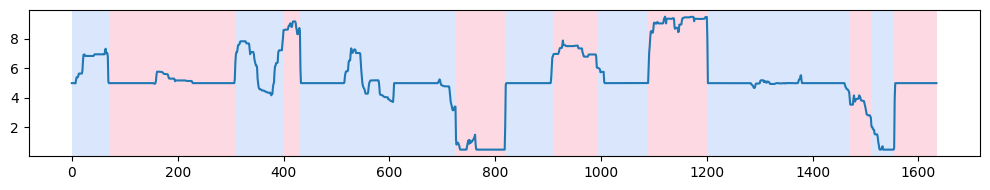

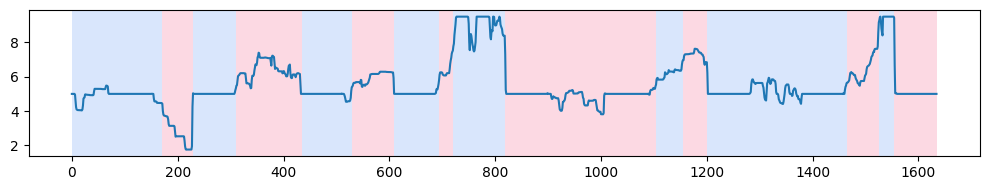

In [102]:
rpt.display(dfs[0][0].values, change_points_all_participants[0][0])
rpt.display(dfs[0][1].values, change_points_all_participants[0][1])

<Figure size 1400x800 with 0 Axes>

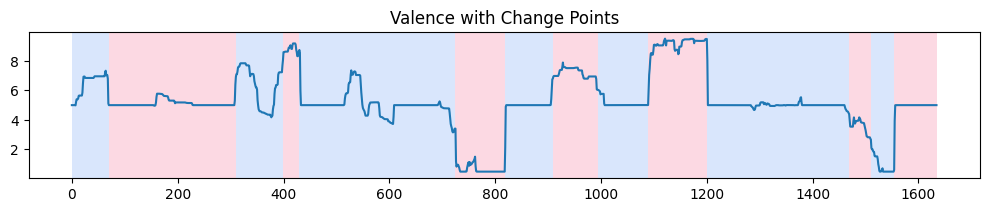

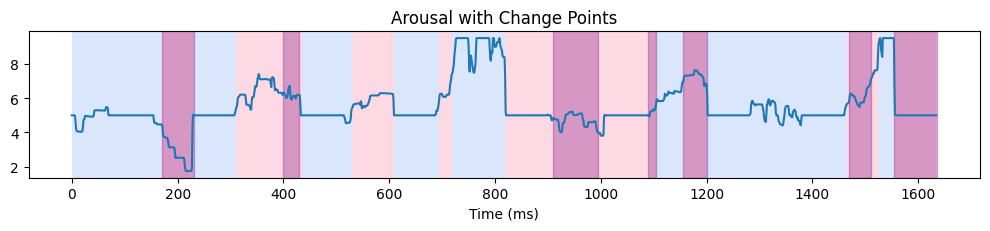

[(170, 230), (400, 430), (910, 995), (1090, 1105), (1155, 1200), (1470, 1510), (1555, 1635)]


In [104]:
def extract_pink_segments(change_points, df):
    segments = []
    previous_cp = 0
    for idx, cp in enumerate(change_points):
        if idx % 2 == 1:  # Select only the pink segments
            segments.append((previous_cp, cp, df.iloc[previous_cp:cp]))
        previous_cp = cp
    if len(change_points) % 2 == 1:  # Ensure the last segment is included if it's pink
        segments.append((previous_cp, len(df), df.iloc[previous_cp:]))
    return segments

# Extract pink segments for the first participant
participant_index = 0
valence_change_points = change_points_all_participants[participant_index][0]
arousal_change_points = change_points_all_participants[participant_index][1]

# Extract the annotation data for the first participant
annotations = annotation_data[participant_index]

# Downsample the data
downsample_factor = 30
time_df = downsample_data(annotations['jstime'].to_frame(), downsample_factor)
valence_df = downsample_data(annotations['valence'].to_frame(), downsample_factor)
arousal_df = downsample_data(annotations['arousal'].to_frame(), downsample_factor)

# Extract pink segments
valence_pink_segments = extract_pink_segments(valence_change_points, valence_df)
arousal_pink_segments = extract_pink_segments(arousal_change_points, arousal_df)

# Find overlapping pink segments
def find_overlapping_segments(valence_segments, arousal_segments):
    overlapping_segments = []
    for v_start, v_end, _ in valence_segments:
        for a_start, a_end, _ in arousal_segments:
            overlap_start = max(v_start, a_start)
            overlap_end = min(v_end, a_end)
            if overlap_start < overlap_end:  # There is an overlap
                overlapping_segments.append((overlap_start, overlap_end))
    return overlapping_segments

# Find the important overlapping pink segments
important_pink_segments = find_overlapping_segments(valence_pink_segments, arousal_pink_segments)

# Plotting using rpt.display and marking important segments
plt.figure(figsize=(14, 8))

# Plot valence change points
rpt.display(valence_df.values, valence_change_points)
plt.title('Valence with Change Points')

# Plot arousal change points
rpt.display(arousal_df.values, arousal_change_points)
plt.title('Arousal with Change Points')

# Highlight important pink segments
for start, end in important_pink_segments:
    plt.axvspan(start, end, color='purple', alpha=0.3)

plt.xlabel('Time (ms)')
plt.show()

# Print important combined segments
print(important_pink_segments)